# AMAT 502: Modern Computing for Mathematicians
## Lecture 18 - The Data Science Pipeline for MNIST
### University at Albany SUNY

# Topics for Today

- The Data Science Pipeline
- Purity of a Clustering
- Using Scikit-Learn's pipeline for PCA+Kmeans
- Comparing Clustering with Classification

# The Data Science Pipeline

> 0. Collect or load data
> 1. Do some **exploratory data analysis** via visualization.
> 2. Consider what **machine learning methods** you want to use.
> 3. Create instances of your data science methods and train on the data.
> 4. Analyze the results.
> 5. Consider different pre-processing steps to re-apply Steps 3 and 4.

This lecture will have two parts, reflecting two different choices made in step 2 on method selection:
- **Part 1** Applying PCA+ KMeans. This is based loosely on [this presentation](https://sbrouil.github.io/ml-sandbox/MNIST+Kaggle+Digit+clusterization+using+KMeans.html).
- **Part 2** Applying KNN.

# The MNIST Data Set

![MnistExamples](MnistExamples.png)

In [1]:
#load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans 
import sklearn.datasets as ds # this should be optional
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Step 0: Loading and Inspecting the MNIST Data Set

In [2]:
#loading a local .csv data set as a Pandas dataFrame
#train = pd.read_csv('full_mnist_train.csv')
#test = pd.read_csv('full_mnist_test.csv')
train = pd.read_csv('small_mnist_train.csv')
test = pd.read_csv('small_mnist_test.csv')

test
test.iloc[:,1].values
train = train.drop(columns=['Unnamed: 0'])
test = test.drop(columns=['Unnamed: 0'])
#test

In [9]:
train.shape
#test.shape
np.sqrt(784)

28.0

### Partitioning the Data Set into Train/Test frames

In [6]:
X_train = train.iloc[:,1:].values 
Y_train = train.iloc[:,0].values
X_test = test.iloc[:,1:].values
Y_test = test.iloc[:,0].values

Y_train[0:20]

array([0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4])

### Down-sample the Data Set

In [7]:
n=5000
n_digits=10
X = X_train[0:n, :]
Y = Y_train[0:n]

## Step 1: Perform Some Initial Data Exploration via Visualization

### Here we use PCA on the first 1000 digits

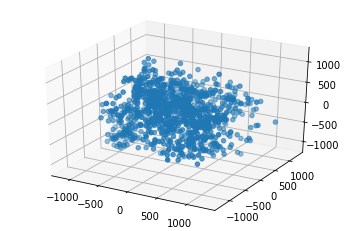

In [11]:
from mpl_toolkits.mplot3d import Axes3D 

pca = PCA(n_components=5)
pca_input = X[:1000,:]
X_pca = pca.fit(pca_input).transform(pca_input)
Y_pca = Y[:1000]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs=X_pca[:,1]
ys=X_pca[:,2]
zs=X_pca[:,3]
ax.scatter(xs, ys, zs)# should modify to color by true label

## Step 2: Considering What ML Methods to Use

Beyond basic visualization and exploration of the data set, we must consider more formal ways of learning from the data. 

> The coarsest invariant of a data set is the classes or clusters it is partitioned into. 

From there, it's worth considering more continuous geometric methods such as regression or dimensionality reduction techniques, such as manifold learning, which is sometimes called [nonlinear dimensionality reduction](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction).


### Why Classification is Easier

However in the clustering versus classification divide, classification is easier because its accuracy is easy to assess. 

> To assess the accuracy of a classification technique, just measure the percentage of correct predictions out of all predictions made.


### Evaluating Quality of a Clustering Schema

For clustering, it is more difficult to determine how good or bad of a job you've done. In fact, in Section 25.1.2 of Kevin Murphy's *Machine Learning: a Probabilistic Perspective* he says

> "The validation of clustering structures is the most difficult and frustrating part of cluster analysis. Without a strong effort in this direction, cluster analysis will remain a black art accessible only to those true believers who have experience and great courage." — Jain and Dubes (Jain and Dubes 1988)

> "Clustering is an unupervised learning technique, so it is hard to evaluate the quality of the output of any given method." - Kevin Murphy in *Machine Learning: a Probabilistic Perspective* Section 25.1.2

Nevertheless, we want to see how clustering techniques perform on the MNIST data set.

# Part 1: K-Means Clustering

Recall that a K-means clustering satisfies a **constrained optimization** problem. One is **constrained** by the number of clusters and one is trying to **minimize the sum with cluster variation** formula.

However, if we treat cluster names as labels, one might ask how successfully one learns the correct cluster label given instances of new samples from the data set.

## The Purity of a Clustering

Let $N_{ij}$ be the number of objects in cluster $i$ that belong to class $j$, and let $N_i = \sum^C_{j=1} N_{ij}$ be the total number of objects in cluster $i$. Define 
$$p_{ij} = N_{ij}/ N_i $$ 
this is the empirical distribution over class labels for cluster $i$. 

## Purity Defined

We define the **purity** of a cluster as 
$$p_i = \max_j p_{ij}$$ 
and the **overall purity of a clustering** as the average of the individual cluster's purities weighted by the size of that cluster, i.e. 
$$\text{purity} = \sum_i \frac{N_i}{N} p_i$$

For example, consider ![purity example](purity.png)

This has $$\text{purity} = \frac{6}{17}\frac{5}{6} + \frac{6}{17}\frac{4}{6} + \frac{5}{17}\frac{3}{5}=.71$$

### Auxiliary Plotting Functions and Purity Calculators, particular to this data set

In [12]:
# These are just auxiliary functions to make nice plots and so some simple statistics
def plot_d(digit, label):
    plt.axis('off')
    plt.imshow(digit.reshape((28,28)), cmap=plt.cm.gray)
    plt.title(label)

def plot_ds(digits, title, labels):
    n=digits.shape[0]
    n_rows=n/25+1
    n_cols=25
    plt.figure(figsize=(n_cols * 0.9, n_rows * 1.3))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plot_d(digits[i,:], "%d" % labels[i])

def plot_clusters(predict, y, stats):
    for i in range(10):
        indices = np.where(predict == i)
        title = "Most freq item %d, cluster size %d, majority %d " % (stats[i,2], stats[i,1], stats[i,0])
        plot_ds(X_train[indices][:25], title, y[indices])

#The clusters_stats might be useful for the K-Means Project!
def clusters_stats(predict, y):
    stats = np.zeros((10,3))
    for i in range(10):
        indices = np.where(predict == i)
        cluster = y[indices]
        stats[i,:] = clust_stats(cluster)
    return stats
        
def clust_stats(cluster):
    class_freq = np.zeros(10)
    for i in range(10):
        class_freq[i] = np.count_nonzero(cluster == i)
    most_freq = np.argmax(class_freq)
    n_majority = np.max(class_freq)
    n_all = np.sum(class_freq)
    return (n_majority, n_all, most_freq)
    
def clusters_purity(clusters_stats):
    majority_sum  = clusters_stats[:,0].sum()
    n = clusters_stats[:,1].sum()
    return majority_sum / n

## Step 3: Creating Instances of PCA and K-Means

In [14]:
n=5000
n_digits = 10
inputs = X[:n,:]

n_components=8

pca = PCA(n_components)
kmeans = KMeans(n_clusters=n_digits,n_init=1)
predictor = Pipeline([('pca', pca), ('kmeans', kmeans)])

predict = predictor.fit(inputs).predict(inputs)

In [19]:
predict.shape

print(predict[0:25])
print(Y_train[0:25])

[4 6 3 7 5 1 9 1 7 9 3 9 2 1 8 5 7 1 1 6 4 7 3 1 9]
[0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2]


## Step 4: Analyzing the Results

Plotting an extract of the 10 clusters, using 8 PCA components. Overall purity: 0.567600


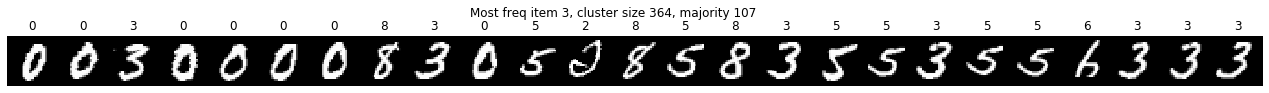

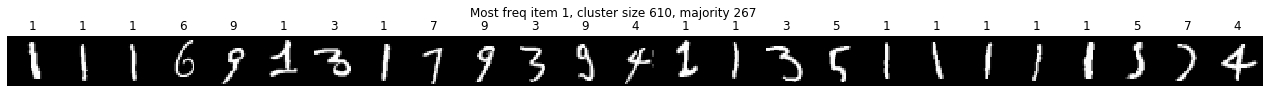

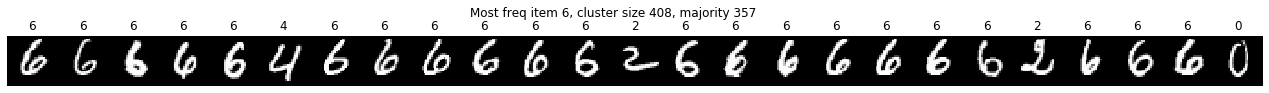

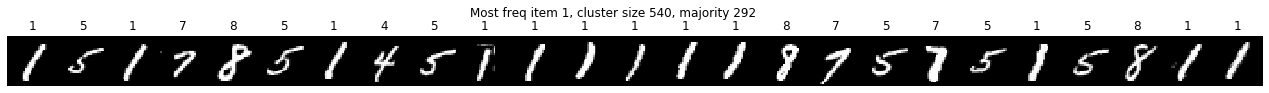

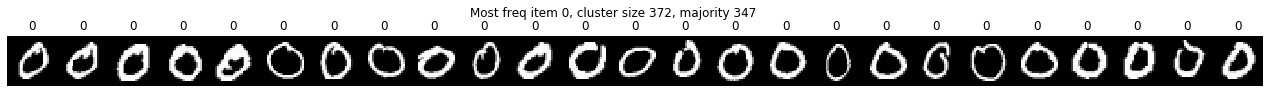

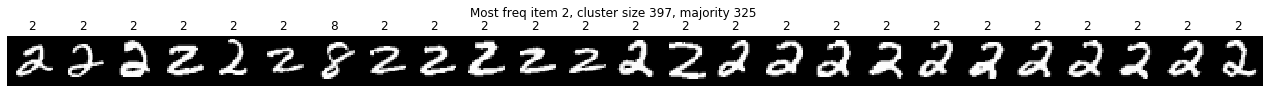

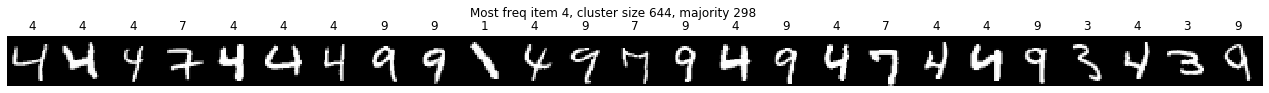

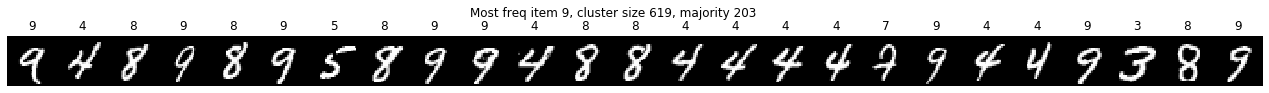

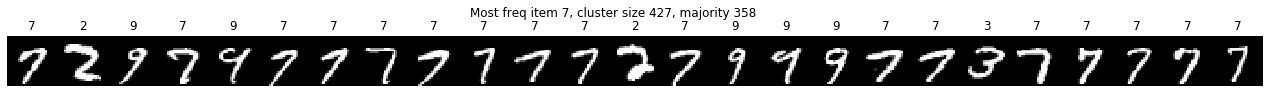

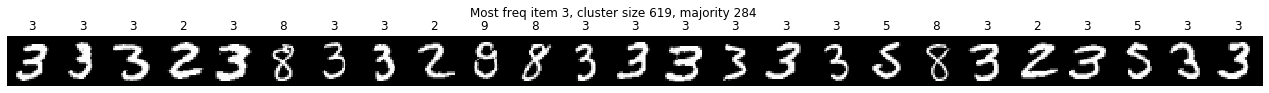

In [20]:
stats = clusters_stats(predict, Y)
purity = clusters_purity(stats)

print("Plotting an extract of the 10 clusters, using " + str(n_components) + " PCA components. Overall purity: %f" % purity)

plot_clusters(predict, Y, stats)

## Step 5: Try Different Pre-Processing Steps

Oftentimes simple pre-processing steps will give much better results.

One of the most common is rescaling data.

For MNIST, this doesn't help much, as we'll see here.

You can check this for yourself using
```python
from sklearn import preprocessing
inputs_scaled = preprocessing.scale(inputs)
```
and repeating the steps above.

# Part 2: Comparison with KNN

In [21]:
#inputs = X[:n,:]

# Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
knn.fit(X[:n,:], Y[:n])

# Predict the response for test dataset
Y_pred = knn.predict(X_test)

In [22]:
Y_test = test.iloc[:,0].values
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.9005


In [21]:
# Import confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

[[172   0   0   0   0   0   3   0   0   0]
 [  0 234   0   0   0   0   0   0   0   0]
 [  7  12 184   1   1   0   3   9   2   0]
 [  0   2   2 184   0   8   1   4   2   4]
 [  0   4   0   0 198   0   3   2   0  10]
 [  2   2   1   4   2 159   2   1   2   4]
 [  3   1   0   0   2   1 172   0   0   0]
 [  0  17   1   0   3   1   0 175   0   7]
 [  5   4   3   8   5   8   3   3 146   7]
 [  0   1   0   2   5   3   0   4   2 177]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       175
           1       0.84      1.00      0.92       234
           2       0.96      0.84      0.90       219
           3       0.92      0.89      0.91       207
           4       0.92      0.91      0.91       217
           5       0.88      0.89      0.89       179
           6       0.92      0.96      0.94       179
           7       0.88      0.86      0.87       204
           8       0.95      0.76      0.84       192
           9       0.85     